In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**DATA ACQUISITION**

In [ ]:
import os
import librosa
import soundfile as sf
import numpy as np
import shutil

# Fungsi membersihkan 1 fold
def clean_audio_per_fold(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    files = sorted([f for f in os.listdir(input_folder) if f.endswith('.wav')])

    for i, fname in enumerate(files):
        fpath = os.path.join(input_folder, fname)
        try:
            y, sr = librosa.load(fpath, sr=22050)

            if len(y) == 0:
                print(f"❌ Kosong: {fname}")
                continue

            duration = librosa.get_duration(y=y, sr=sr)
            if duration < 4.0:
                print(f"⚠️ Durasi < 4 detik: {fname}")
                continue

            # Hitung volume (dB)
            rms = np.sqrt(np.mean(y**2))
            db = 20 * np.log10(rms + 1e-6)

            print(f"✅ {fname} | durasi: {duration:.2f}s | volume: {db:.2f} dB")

            # Simpan
            new_name = f"{i}.wav"
            sf.write(os.path.join(output_folder, new_name), y, 22050)

        except Exception as e:
            print(f"❌ Rusak: {fname} | Error: {str(e)}")

# Fungsi gabung semua cleaned folder
def combine_cleaned_folds(clean_root_folder, output_final_folder):
    os.makedirs(output_final_folder, exist_ok=True)
    idx = 0
    for folder in sorted(os.listdir(clean_root_folder)):
        fold_path = os.path.join(clean_root_folder, folder)
        if not os.path.isdir(fold_path): continue
        for file in sorted(os.listdir(fold_path)):
            src = os.path.join(fold_path, file)
            dst = os.path.join(output_final_folder, f"audio_{idx}.wav")
            shutil.copy2(src, dst)
            idx += 1
    print(f"\n🎉 Gabung selesai: {idx} file tersimpan di {output_final_folder}")

# === MAIN LOOP ===
root_input = '/content/drive/MyDrive/Dataset_audio'
root_cleaned = '/content/drive/MyDrive/Dataset_audio_clean'
final_output = '/content/drive/MyDrive/dataset_audioFIX'

# Bersihkan per fold
all_folders = sorted([f for f in os.listdir(root_input) if f.startswith("fold")])
for fold in all_folders:
    print(f"\n📁 Memproses: {fold}")
    input_path = os.path.join(root_input, fold)
    output_path = os.path.join(root_cleaned, fold + '_clean')
    clean_audio_per_fold(input_path, output_path)

# Gabungkan hasil ke satu folder final
combine_cleaned_folds(root_cleaned, final_output)


In [ ]:
dataset_path = '/content/drive/MyDrive/dataset_audioFIX'

# Fungsi hitung dBFS dan estimasi dB SPL
def calculate_volume_dbspl(file_path):
    y, sr = librosa.load(file_path, sr=22050)

    if len(y) == 0:
        return None, None  # skip file kosong

    rms = np.sqrt(np.mean(y**2))
    dbfs = 20 * np.log10(rms)  # dBFS

    # Konversi ke estimasi dB SPL (asumsi)
    db_spl = dbfs + 90
    return dbfs, db_spl

# Iterasi dan cetak hasil
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.wav'):
            filepath = os.path.join(root, file)
            dbfs, db_spl = calculate_volume_dbspl(filepath)
            if dbfs is not None:
                print(f"{file} | dBFS: {dbfs:.2f} dB | Estimasi dB SPL: {db_spl:.2f} dB")

Output streaming akan dipotong hingga 5000 baris terakhir.
audio_4333.wav | dBFS: -24.63 dB | Estimasi dB SPL: 65.37 dB
audio_4334.wav | dBFS: -25.36 dB | Estimasi dB SPL: 64.64 dB
audio_4335.wav | dBFS: -26.62 dB | Estimasi dB SPL: 63.38 dB
audio_4336.wav | dBFS: -25.05 dB | Estimasi dB SPL: 64.95 dB
audio_4337.wav | dBFS: -17.33 dB | Estimasi dB SPL: 72.67 dB
audio_4338.wav | dBFS: -15.40 dB | Estimasi dB SPL: 74.60 dB
audio_4339.wav | dBFS: -16.46 dB | Estimasi dB SPL: 73.54 dB
audio_4340.wav | dBFS: -16.97 dB | Estimasi dB SPL: 73.03 dB
audio_4341.wav | dBFS: -17.14 dB | Estimasi dB SPL: 72.86 dB
audio_4342.wav | dBFS: -22.30 dB | Estimasi dB SPL: 67.70 dB
audio_4343.wav | dBFS: -20.78 dB | Estimasi dB SPL: 69.22 dB
audio_4344.wav | dBFS: -18.13 dB | Estimasi dB SPL: 71.87 dB
audio_4345.wav | dBFS: -17.21 dB | Estimasi dB SPL: 72.79 dB
audio_4346.wav | dBFS: -17.08 dB | Estimasi dB SPL: 72.92 dB
audio_4347.wav | dBFS: -17.16 dB | Estimasi dB SPL: 72.84 dB
audio_4348.wav | dBFS: -31

In [ ]:
import os
import librosa
import numpy as np
import shutil

# Path asal dan tujuan
source_path = '/content/drive/MyDrive/dataset_audioFIX'
target_path = '/content/drive/MyDrive/dataset_klasifikasi'
meltdown_path = os.path.join(target_path, 'meltdown')
non_meltdown_path = os.path.join(target_path, 'non_meltdown')

# Buat folder tujuan jika belum ada
os.makedirs(meltdown_path, exist_ok=True)
os.makedirs(non_meltdown_path, exist_ok=True)

# Fungsi hitung dB SPL
def calculate_db_spl(filepath):
    y, sr = librosa.load(filepath, sr=22050)
    if len(y) == 0:
        return None  # skip file kosong
    rms = np.sqrt(np.mean(y**2))
    dbfs = 20 * np.log10(rms + 1e-6)  # tambah epsilon untuk hindari log(0)
    db_spl = dbfs + 90  # estimasi konversi dB SPL
    return db_spl

# Iterasi file audio
for root, dirs, files in os.walk(source_path):
    for file in files:
        if file.endswith('.wav'):
            full_path = os.path.join(root, file)
            db_spl = calculate_db_spl(full_path)

            if db_spl is not None:
                # Tentukan folder target berdasarkan ambang batas
                if db_spl >= 70:
                    dest_folder = meltdown_path
                else:
                    dest_folder = non_meltdown_path

                # Salin file ke folder target
                shutil.copy(full_path, os.path.join(dest_folder, file))

                print(f"{file} | SPL: {db_spl:.2f} dB SPL → {os.path.basename(dest_folder)}")

In [ ]:
import os

# Path folder yang sudah diubah namanya
meltdown_folder = '/content/drive/MyDrive/dataset_klasifikasi/meltdown'
non_meltdown_folder = '/content/drive/MyDrive/dataset_klasifikasi/non_meltdown'

# Ambil daftar file
meltdown_files = os.listdir(meltdown_folder)
non_meltdown_files = os.listdir(non_meltdown_folder)

# Mengubah nama file di dalam folder high_sensitivity (meltdown)
for file in meltdown_files:
    # Menambahkan label high ke nama file
    old_path = os.path.join(meltdown_folder, file)
    new_file_name = f"meltdown_{file}"
    new_path = os.path.join(meltdown_folder, new_file_name)
    os.rename(old_path, new_path)

# Mengubah nama file di dalam folder low_sensitivity (non_meltdown)
for file in non_meltdown_files:
    # Menambahkan label low ke nama file
    old_path = os.path.join(non_meltdown_folder, file)
    new_file_name = f"non_meltdown_{file}"  # Menambahkan 'low_' pada nama file
    new_path = os.path.join(non_meltdown_folder, new_file_name)
    os.rename(old_path, new_path)

# Hitung jumlah file di folder
meltdown_count = len(os.listdir(meltdown_folder))
non_meltdown_count = len(os.listdir(non_meltdown_folder))

# Tampilkan jumlah file
print(f"📁 Jumlah file di folder meltdown setelah diberi label: {meltdown_count}")
print(f"📁 Jumlah file di folder non_meltdown setelah diberi label: {non_meltdown_count}")


📁 Jumlah file di folder meltdown setelah diberi label: 2425
📁 Jumlah file di folder non_meltdown setelah diberi label: 7004


**DATA UNDERSTANDING**

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np

# Path folder yang sudah diganti
meltdown_folder = '/content/drive/MyDrive/dataset_klasifikasi/meltdown'
non_meltdown_folder = '/content/drive/MyDrive/dataset_klasifikasi/non_meltdown'

def extract_audio_info(folder, label):
    data = []
    for filename in os.listdir(folder):
        if filename.endswith('.wav'):
            filepath = os.path.join(folder, filename)
            try:
                y, sr = librosa.load(filepath, sr=22050)
                duration = librosa.get_duration(y=y, sr=sr)
                rms = librosa.feature.rms(y=y).mean()
                db = 20 * np.log10(rms)  # dBFS
                data.append({
                    'filename': filename,
                    'duration_sec': round(duration, 2),
                    'volume_db': round(db, 2),
                    'label': label
                })
            except Exception as e:
                print(f"⚠️ Error reading {filename}: {e}")
    return pd.DataFrame(data)

# Ekstrak info dari kedua folder yang sudah diganti namanya
meltdown_df = extract_audio_info(meltdown_folder, 'meltdown')
non_meltdown_df = extract_audio_info(non_meltdown_folder, 'non_meltdown')

# Gabungkan data
audio_df = pd.concat([meltdown_df, non_meltdown_df], ignore_index=True)

In [ ]:
audio_df.head()

,filename,duration_sec,volume_db,label
0,audio_5043.wav,4.0,-18.730000,meltdown
1,audio_5044.wav,4.0,-18.990000,meltdown
2,audio_5045.wav,4.0,-18.870001,meltdown
3,audio_5102.wav,4.0,-15.860000,meltdown
4,audio_5252.wav,4.0,-17.850000,meltdown


Statistik Deskriptif Awal

In [ ]:
# Statistik volume per kelas
audio_df.groupby('label')['volume_db'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
meltdown,2389.0,-16.967920,3.637082,-31.200001,-19.360001,-17.34,-14.720,-3.980000
non_meltdown,6943.0,-30.909904,8.160690,-75.080002,-35.529999,-29.02,-24.575,-20.059999


Visualisasi Distribusi Volume

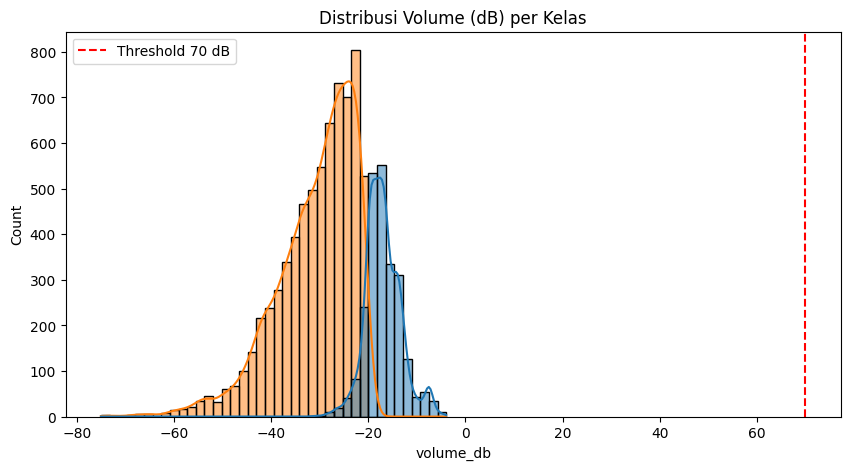

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(data=audio_df, x='volume_db', hue='label', bins=40, kde=True)
plt.axvline(x=70, color='red', linestyle='--', label='Threshold 70 dB')
plt.title('Distribusi Volume (dB) per Kelas')
plt.legend()
plt.show()

Durasi Audio

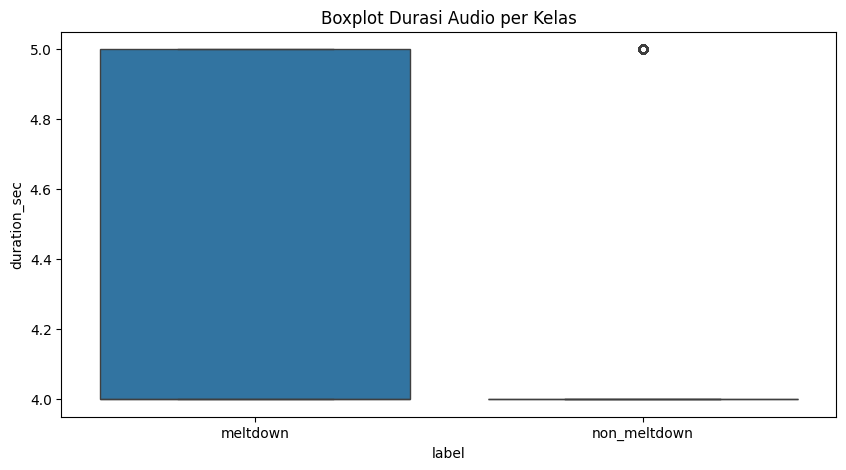

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=audio_df, x='label', y='duration_sec')
plt.title('Boxplot Durasi Audio per Kelas')
plt.show()

**UNDERSAMPLING**

In [ ]:
import os
import shutil
import random

# Path folder asal
non_meltdown_src = '/content/drive/MyDrive/dataset_klasifikasi/non_meltdown'
meltdown_src = '/content/drive/MyDrive/dataset_klasifikasi/meltdown'

# Path folder tujuan yang sudah seimbang
balanced_folder = '/content/drive/MyDrive/dataset_balanced'
meltdown_dst = os.path.join(balanced_folder, 'meltdown')
non_meltdown_dst = os.path.join(balanced_folder, 'non_meltdown')

# Buat folder baru
os.makedirs(meltdown_dst, exist_ok=True)
os.makedirs(non_meltdown_dst, exist_ok=True)

# Salin semua file dari folder meltdown
for fname in os.listdir(meltdown_src):
    src_file = os.path.join(meltdown_src, fname)
    dst_file = os.path.join(meltdown_dst, fname)
    shutil.copy2(src_file, dst_file)

# Undersampling non-meltdown
non_meltdown_files = os.listdir(non_meltdown_src)
sampled_non_meltdown = random.sample(non_meltdown_files, 2389)

# Salin file yang diambil secara acak
for fname in sampled_non_meltdown:
    src_file = os.path.join(non_meltdown_src, fname)
    dst_file = os.path.join(non_meltdown_dst, fname)
    shutil.copy2(src_file, dst_file)

print("✅ Undersampling selesai. Dataset sekarang seimbang.")

✅ Undersampling selesai. Dataset sekarang seimbang.


In [ ]:
import os

# Path folder klasifikasi
meltdown_folder = '/content/drive/MyDrive/dataset_balanced/meltdown'
non_meltdown_folder = '/content/drive/MyDrive/dataset_balanced/non_meltdown'

# Ambil daftar file
meltdown_files = os.listdir(meltdown_folder)
non_meltdown_files = os.listdir(non_meltdown_folder)

# Tampilkan
print(f"📂 Jumlah file di folder 'meltdown'     : {len(meltdown_files)}")
print(f"📂 Jumlah file di folder 'non_meltdown': {len(non_meltdown_files)}")

📂 Jumlah file di folder 'meltdown'     : 2389
📂 Jumlah file di folder 'non_meltdown': 2390


**DATA PRE-PROCESSING**

In [ ]:
import numpy as np
np.complex = complex  # Untuk kompatibilitas librosa terbaru

import librosa
import os
from sklearn.preprocessing import LabelEncoder

# Path dataset seimbang
data_dir = '/content/drive/MyDrive/dataset_balanced'
labels = ['meltdown', 'non_meltdown']

# Konfigurasi audio
sr = 22050
n_mfcc = 40
durasi = 4  # durasi target dalam detik

X = []
y = []

# Proses semua audio
for label in labels:
    folder_path = os.path.join(data_dir, label)
    for fname in os.listdir(folder_path):
        file_path = os.path.join(folder_path, fname)
        try:
            # Load audio
            audio, _ = librosa.load(file_path, sr=sr)

            # Potong/pad jadi 4 detik
            target_len = sr * durasi
            if len(audio) < target_len:
                audio = np.pad(audio, (0, target_len - len(audio)))
            else:
                audio = audio[:target_len]

            # Ekstrak MFCC
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfcc.T, axis=0)  # shape (40,)

            # Estimasi volume dBFS
            rms = np.sqrt(np.mean(audio**2))
            volume_db = 20 * np.log10(rms + 1e-6)

            # Gabung MFCC + volume jadi fitur (41 elemen)
            fitur_akhir = np.append(mfcc_mean, volume_db)
            X.append(fitur_akhir)
            y.append(label)

        except Exception as e:
            print(f"⚠️ Gagal proses {fname}: {e}")

# Konversi ke array
X = np.array(X)
y = np.array(y)

# Encode label (meltdown=0, non_meltdown=1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"✅ Ekstraksi selesai. Shape fitur: {X.shape}, Label: {set(y_encoded)}")

✅ Ekstraksi selesai. Shape fitur: (4778, 41), Label: {np.int64(0), np.int64(1)}


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Simpan X dan y (optional kalau belum disimpan)
np.save('/content/drive/MyDrive/X_mfcc_volume.npy', X)  # Sekarang X punya 41 fitur
np.save('/content/drive/MyDrive/y_mfcc_volume.npy', y_encoded)

# 2. Reshape untuk 1D CNN
#    (samples, timesteps=41, channels=1) karena ada 41 fitur: 40 MFCC + 1 volume
X_cnn = X.reshape((X.shape[0], X.shape[1], 1))

# 3. Split data: 70% Train, 15% Val, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cnn, y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

# 4. Tampilkan bentuk akhir dataset
print(f"Train:      X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape},   y={y_val.shape}")
print(f"Test:       X={X_test.shape},  y={y_test.shape}")

Train:      X=(3344, 41, 1), y=(3344,)
Validation: X=(717, 41, 1),   y=(717,)
Test:       X=(717, 41, 1),  y=(717,)


**MODEL 1D-CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Konfigurasi parameter
input_shape = (X_train.shape[1], 1)  # Harus (timesteps, channels), misal (41, 1)

# Definisikan model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output: sigmoid untuk 1 neuron → binary classification
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping untuk cegah overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Training model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

print("\n✅ Pelatihan model selesai.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6408 - loss: 1.0646 - val_accuracy: 0.8020 - val_loss: 0.5230
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7457 - loss: 0.5286 - val_accuracy: 0.7992 - val_loss: 0.4588
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7688 - loss: 0.4834 - val_accuracy: 0.7908 - val_loss: 0.4468
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7661 - loss: 0.4710 - val_accuracy: 0.8020 - val_loss: 0.4256
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7912 - loss: 0.4479 - val_accuracy: 0.8173 - val_loss: 0.4118
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7871 - loss: 0.4485 - val_accuracy: 0.8159 - val_loss: 0.4051
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8129 - loss: 0.4071 - val_accuracy: 0.8131 - val_loss: 0.4113
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8143 - loss: 0.4104 - val_accu

/tmp/ipython-input-9-755955144.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


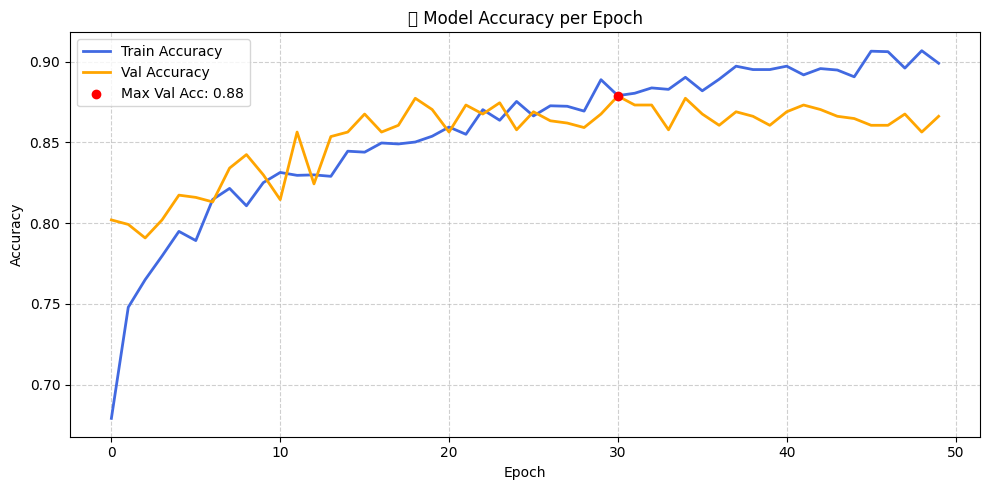

/tmp/ipython-input-9-755955144.py:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


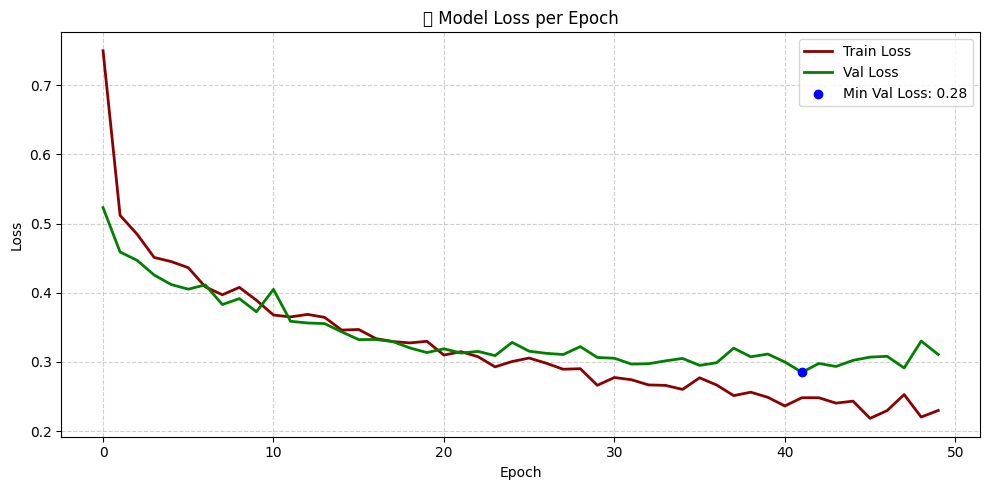

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Akurasi ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='royalblue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange', linewidth=2)

# Tandai titik akurasi tertinggi
max_val_acc = max(history.history['val_accuracy'])
max_epoch = np.argmax(history.history['val_accuracy'])
plt.scatter(max_epoch, max_val_acc, color='red', label=f'Max Val Acc: {max_val_acc:.2f}', zorder=5)

plt.title('📈 Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='darkred', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='green', linewidth=2)

# Tandai titik val loss terendah
min_val_loss = min(history.history['val_loss'])
min_epoch = np.argmin(history.history['val_loss'])
plt.scatter(min_epoch, min_val_loss, color='blue', label=f'Min Val Loss: {min_val_loss:.2f}', zorder=5)

plt.title('📉 Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

**EVALUATION**

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/tmp/ipython-input-10-1424234509.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


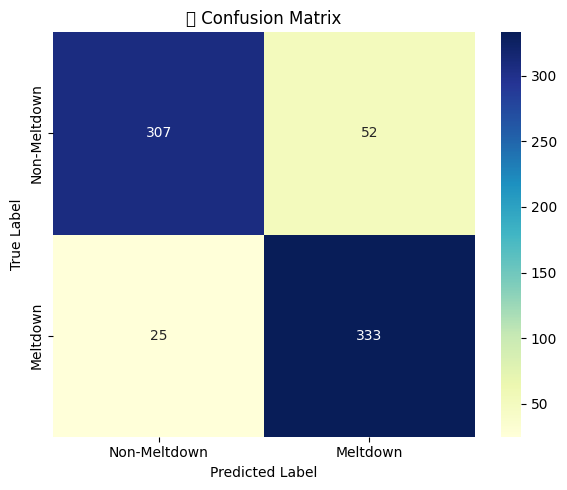

📋 Classification Report:

              precision    recall  f1-score   support

Non-Meltdown     0.9247    0.8552    0.8886       359
    Meltdown     0.8649    0.9302    0.8964       358

    accuracy                         0.8926       717
   macro avg     0.8948    0.8927    0.8925       717
weighted avg     0.8949    0.8926    0.8925       717


✅ Overall Accuracy: 0.8926


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi probabilitas & konversi ke class
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Non-Meltdown', 'Meltdown']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('📊 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 3. Classification Report
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# 4. Accuracy Manual
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Overall Accuracy: {acc:.4f}")

**SIMPAN MODEL**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Simpan ke dalam folder Drive kamu
model.save('/content/drive/MyDrive/cnn_meltdown_model.h5')
print("✅ Model disimpan ke Google Drive: cnn_meltdown_model.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model disimpan ke Google Drive: cnn_meltdown_model.h5


**UJI MODEL DENGAN INPUT DATA BARU**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import librosa
import tensorflow as tf
import gradio as gr

# Load model yang sudah dilatih
model = tf.keras.models.load_model('/content/drive/MyDrive/cnn_meltdown_model.h5')

# Fungsi prediksi
def predict_meltdown(audio_file):
    # Load audio
    y, sr = librosa.load(audio_file, sr=22050)

    # Estimasi volume dBFS
    rms = np.sqrt(np.mean(y**2))
    volume_db = 20 * np.log10(rms + 1e-6)

    # Potong atau padding ke 4 detik
    if len(y) < sr * 4:
        y = np.pad(y, (0, sr * 4 - len(y)))
    else:
        y = y[:sr * 4]

    # Estimasi volume SPL dari dBFS
    volume_spl = volume_db + 90


    # Ekstraksi MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    mfcc_input = mfcc_mean.reshape(1, 40, 1)

    # Estimasi volume
    rms = np.sqrt(np.mean(y**2))
    volume_db = 20 * np.log10(rms + 1e-6)

    # Gabungkan MFCC + volume jadi array input
    fitur_input = np.append(mfcc_mean, volume_db).reshape(1, 41, 1)

    # Prediksi
    prediction = model.predict(fitur_input)[0][0]
    label = "MELTDOWN" if prediction >= 0.5 else "NON_MELTDOWN"

    # Output yang ditampilkan di UI
    result_text = (
    f"✅ Prediksi: {label}\n"
    f"📊 Probabilitas meltdown : {prediction:.4f}\n"
    f"🔊 Estimasi volume (dBFS): {volume_db:.2f} dBFS\n"
    f"🎚️ Estimasi volume (dB SPL): {volume_spl:.2f} dB SPL"
    )
    return result_text, audio_file

# Gradio UI
interface = gr.Interface(
    fn=predict_meltdown,
    inputs=gr.Audio(type="filepath", label="🎧 Upload file audio (.wav)"),
    outputs=[
        gr.Textbox(label="📋 Hasil Prediksi"),
        gr.Audio(label="🔁 Audio Playback")
    ],
    title="🔊 Pengukur Sensitivitas Suara untuk Deteksi Potensi Meltdown pada Teman Autis",
    description="Upload file audio berdurasi minimal 4 detik untuk memprediksi potensi meltdown. Model akan menampilkan prediksi, probabilitas, dan estimasi volume dBFS.",
    allow_flagging="never"
)

interface.launch()

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://49aa60708a496af7a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
